# ST000369
### AdaBoost Classifier
Questo dataset, basato su spettrometria di massa a gas-cromatografia (GC-MS), contiene 181 metaboliti identificati nel siero e nel plasma. In questa analisi confrontiamo il gruppo di pazienti con adenocarcinoma polmonare (Classe=1) con il gruppo di controllo sano (Classe=0).

### 1. Import Packages

In [70]:
# Librerie di base
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Librerie per la Data Imputation
from sklearn.impute import KNNImputer

# Librerie per i test di significatività statistica
import scipy.stats as stats

# Librerie per il Machine Learning
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict

# Librerie per la Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV

# Librerie per la Features Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Librerie per la PCA
from sklearn.decomposition import PCA

# Librerie per la curva ROC
from sklearn.metrics import roc_curve, auc

print('All packages successfully loaded')

All packages successfully loaded


### 2. Load Data & Peak Sheet

In [71]:
df = pd.read_excel('../../../data/ST000369.xlsx')

# Rimuoviamo le colonne che non ci servono
df.drop(columns=["Idx", "SampleID", "Class"], inplace=True)

# Visualizziamo le prime 5 righe del dataset
df.head()

SampleType     HealthState SmokingStatus Sex   M1   M2   M3      M4   M5  \
0     Plasma  Adenocarcinoma        Former   F  194  168   77  105985  118   
1     Plasma  Adenocarcinoma        Former   F  215  143  154  100462  133   
2     Plasma  Adenocarcinoma       Current   F  104   67   45   75301   94   
3     Plasma  Adenocarcinoma       Current   M  360  642   82   42097   84   
4     Plasma  Adenocarcinoma       Current   M   96  137   95  112346  168   

      M6  ...  M172  M173  M174  M175   M176  M177  M178  M179  M180  M181  
0  15489  ...   195  1606   300   108   7203    43    59  1009   383    68  
1  13534  ...   184   364  1364   160  11910    82    99   136  1021   165  
2   7390  ...   189   157   884    73   6372    59    35   115   530    72  
3  50943  ...   320  1621   461   104  14011    69    86   845  1309   127  
4  41987  ...    84   769   266   158  18140    40    87  1213  1037   149  

[5 rows x 185 columns]

### 2.1 Data Cleaning

Per quanto riguarda il data cleaning del dataset, sono necessarie due tipologie di operazioni sui dati: 
1. Alcuni valori della feature "*HealthState*" sono scritti incorrettamente, perciò dobbiamo effettuarne la correzione.
2. Tre features binarie sono espresse attraverso stringhe e non valori binari (0 e 1), perciò dobbiamo fare la sostituzione.

In [72]:
# Effettuiamo la correzione dei valori errati
df["HealthState"] = df["HealthState"].str.replace('Adenocarcnoma', 'Adenocarcinoma')

# Eliminiamo le righe con valori nulli all'interno delle colonne "HealthState" e "Sex"
df = df.dropna(subset=["HealthState", "Sex"])

# Convertiamo i valori di natura categorica in valori numerici
df['Output'] = df['HealthState'].apply(lambda x: 1 if x in ['Adenosquamous', 'Adenocarcinoma'] else 0)
df['SmokingStatus'] = df['SmokingStatus'].apply(lambda x: 1 if x in ['Current'] else 0)
df['Sex'] = df['Sex'].apply(lambda x: 1 if x in ['F'] else 0)

# Visualizziamo le prime 5 righe del dataset
df.head()

SampleType     HealthState  SmokingStatus  Sex   M1   M2   M3      M4   M5  \
0     Plasma  Adenocarcinoma              0    1  194  168   77  105985  118   
1     Plasma  Adenocarcinoma              0    1  215  143  154  100462  133   
2     Plasma  Adenocarcinoma              1    1  104   67   45   75301   94   
3     Plasma  Adenocarcinoma              1    0  360  642   82   42097   84   
4     Plasma  Adenocarcinoma              1    0   96  137   95  112346  168   

      M6  ...  M173  M174  M175   M176  M177  M178  M179  M180  M181  Output  
0  15489  ...  1606   300   108   7203    43    59  1009   383    68       1  
1  13534  ...   364  1364   160  11910    82    99   136  1021   165       1  
2   7390  ...   157   884    73   6372    59    35   115   530    72       1  
3  50943  ...  1621   461   104  14011    69    86   845  1309   127       1  
4  41987  ...   769   266   158  18140    40    87  1213  1037   149       1  

[5 rows x 186 columns]

### 3. Extract X & Y

In [73]:
X = df.drop(columns=['SampleType', 'HealthState', 'Output'])
X_features_names = X.columns
y = df.Output

### 3.1 Data Imputation

In [76]:
# KNNImputer
imputer_knn = KNNImputer()
imputer_knn.fit(X)
X[:] = imputer_knn.fit_transform(X)
X_knn = X.copy()

### 3.2 Train-test Split

In [77]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y, test_size=0.2, random_state=42)

### 4. Initial Model Build

In [78]:
# Definiamo il modello AdaBoost Classifier con gli iperparametri di default
model = AdaBoostClassifier()

# Addestriamo il modello
model.fit(X_train_knn, y_train_knn)

# Eseguiamo le previsioni sui dati di test
y_pred_knn = model.predict(X_test_knn)

### 5. Initial Model Evalutation

In [79]:
# Valutiamo le metriche con gli iperparametri di default
accuracy_knn = metrics.accuracy_score(y_test_knn, y_pred_knn)
precision_knn = metrics.precision_score(y_test_knn, y_pred_knn)
recall_knn = metrics.recall_score(y_test_knn, y_pred_knn)
f1_knn = metrics.f1_score(y_test_knn, y_pred_knn)
roc_auc_knn = metrics.roc_auc_score(y_test_knn, y_pred_knn)

# Stampiamo le metriche
print(f'Accuratezza: {accuracy_knn}')
print(f'Precision: {precision_knn}')
print(f'Recall: {recall_knn}')
print(f'F1-score: {f1_knn}')
print(f'ROC AUC: {roc_auc_knn}')

Accuratezza: 0.6666666666666666
Precision: 0.65
Recall: 0.7647058823529411
F1-score: 0.7027027027027027
ROC AUC: 0.6636029411764706


Abbiamo un'accuratezza di 66%, una Precision di 65% e una Recall di 76%. Proviamo con la K-Fold Cross Validation.

In [86]:
# Testiamo diverse configurazioni di K (range: 5-10)
max = 0
k_best = 0
model = AdaBoostClassifier()
for k in range(5, 11): 
    kfolds = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_knn, y, cv=kfolds)
    mean = np.mean(scores)
    if mean > max: 
        max = mean
        k_best = k
    print(f"K={k}, Accuratezza Media: {mean}")

print("-------------------------------------------")
print(f"K ottimale: {k_best}")
print(f"Accuratezza Media ottimale: {max}")

K=5, Accuratezza Media: 0.687689393939394
K=6, Accuratezza Media: 0.7114197530864198
K=7, Accuratezza Media: 0.7060041407867496
K=8, Accuratezza Media: 0.7175595238095238
K=9, Accuratezza Media: 0.7797270955165692
K=10, Accuratezza Media: 0.6886029411764706
-------------------------------------------
K ottimale: 9
Accuratezza Media ottimale: 0.7797270955165692


Il numero ottimale di fold è 9. 

In [82]:
# Creiamo l'oggetto K-Fold per la Cross Validation con il numero di fold ottimale
kfolds = KFold(n_splits=k_best, shuffle=True, random_state=42)

### 6. Hyperparameters Optimization

L'**ottimizzazione degli iperparametri** è un passo fondamentale nello sviluppo di modelli predittivi robusti. Infatti, aderire ai parametri predefiniti impedisce ai modelli di raggiungere il massimo delle prestazioni. A tale scopo, utilizziamo la tecnica **Grid Search**.

In [84]:
# Creiamo un nuovo modello
model_2 = AdaBoostClassifier()

# Definiamo la griglia con i parametri da testare
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],           
    'learning_rate': [0.01, 0.1, 1.0, 10],        
    'estimator': [None, DecisionTreeClassifier(max_depth=1)],
    'algorithm': ['SAMME', 'SAMME.R'],    
    'random_state': [42]
}

# Grid Search
grid_search = GridSearchCV(model_2, param_grid, scoring='accuracy', cv=kfolds, n_jobs=-1)
grid_search.fit(X_knn, y)

# Visualizziamo i risultati
best_params = grid_search.best_params_
print("Iperparametri migliori:", best_params)

Iperparametri migliori: {'algorithm': 'SAMME', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 150, 'random_state': 42}


In [88]:
# Utilizziamo gli iperparametri ottimizzati per creare un nuovo modello
best_model = AdaBoostClassifier(**best_params)
best_model.fit(X_train_knn, y_train_knn)
y_pred_knn = best_model.predict(X_test_knn)

In [89]:
# Valutiamo le prestazioni del modello con gli iperparametri di default
accuracy_knn = metrics.accuracy_score(y_test_knn, y_pred_knn)
precision_knn = metrics.precision_score(y_test_knn, y_pred_knn)
recall_knn = metrics.recall_score(y_test_knn, y_pred_knn)
f1_knn = metrics.f1_score(y_test_knn, y_pred_knn)
roc_auc_knn = metrics.roc_auc_score(y_test_knn, y_pred_knn)

print(f'Accuratezza: {accuracy_knn}')
print(f'Precision: {precision_knn}')
print(f'Recall: {recall_knn}')
print(f'F1-score: {f1_knn}')
print(f'ROC AUC: {roc_auc_knn}')

Accuratezza: 0.7272727272727273
Precision: 0.6818181818181818
Recall: 0.8823529411764706
F1-score: 0.7692307692307693
ROC AUC: 0.7224264705882353


In [90]:
# KFold Cross Validation
scores = cross_val_score(best_model, X_knn, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.74375


### 7. Feature Selection

In [91]:
max_fs = 0 
k_fs = 0
best_features = []

for k in range(2, len(X_knn.columns)):
    top_features = SelectKBest(score_func=chi2, k=k).fit(X_knn, y).get_support(indices=True)
    X_top = X_knn.iloc[:, top_features]
    
    scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
    mean = np.mean(scores)
    
    if mean > max_fs: 
        max_fs = mean
        k_fs = k
        best_features = X_knn.columns[top_features].tolist()

    print(f"K={k}, Accuratezza Media: {mean}")

print(f"K ottimale: {k_fs}")
print(f"Accuratezza media ottimale: {max_fs}")
print(f"Features ottimali: {best_features}")

K=2, Accuratezza Media: 0.5470588235294118
K=3, Accuratezza Media: 0.5889705882352941
K=4, Accuratezza Media: 0.5716911764705882
K=5, Accuratezza Media: 0.6077205882352941
K=6, Accuratezza Media: 0.6378676470588236
K=7, Accuratezza Media: 0.6926470588235294
K=8, Accuratezza Media: 0.7113970588235293
K=9, Accuratezza Media: 0.7055147058823529
K=10, Accuratezza Media: 0.7125
K=11, Accuratezza Media: 0.7183823529411765
K=12, Accuratezza Media: 0.7003676470588236
K=13, Accuratezza Media: 0.7180147058823529
K=14, Accuratezza Media: 0.7297794117647058
K=15, Accuratezza Media: 0.6996323529411764
K=16, Accuratezza Media: 0.6996323529411764
K=17, Accuratezza Media: 0.7183823529411765
K=18, Accuratezza Media: 0.6875
K=19, Accuratezza Media: 0.7121323529411765
K=20, Accuratezza Media: 0.7356617647058823
K=21, Accuratezza Media: 0.7121323529411765
K=22, Accuratezza Media: 0.7180147058823529
K=23, Accuratezza Media: 0.7066176470588236
K=24, Accuratezza Media: 0.7
K=25, Accuratezza Media: 0.74301470

In [48]:
X_top = X_knn[best_features]
scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.8099415204678362


Visualizziamo la matrice di correlazione tra le features ottenute.

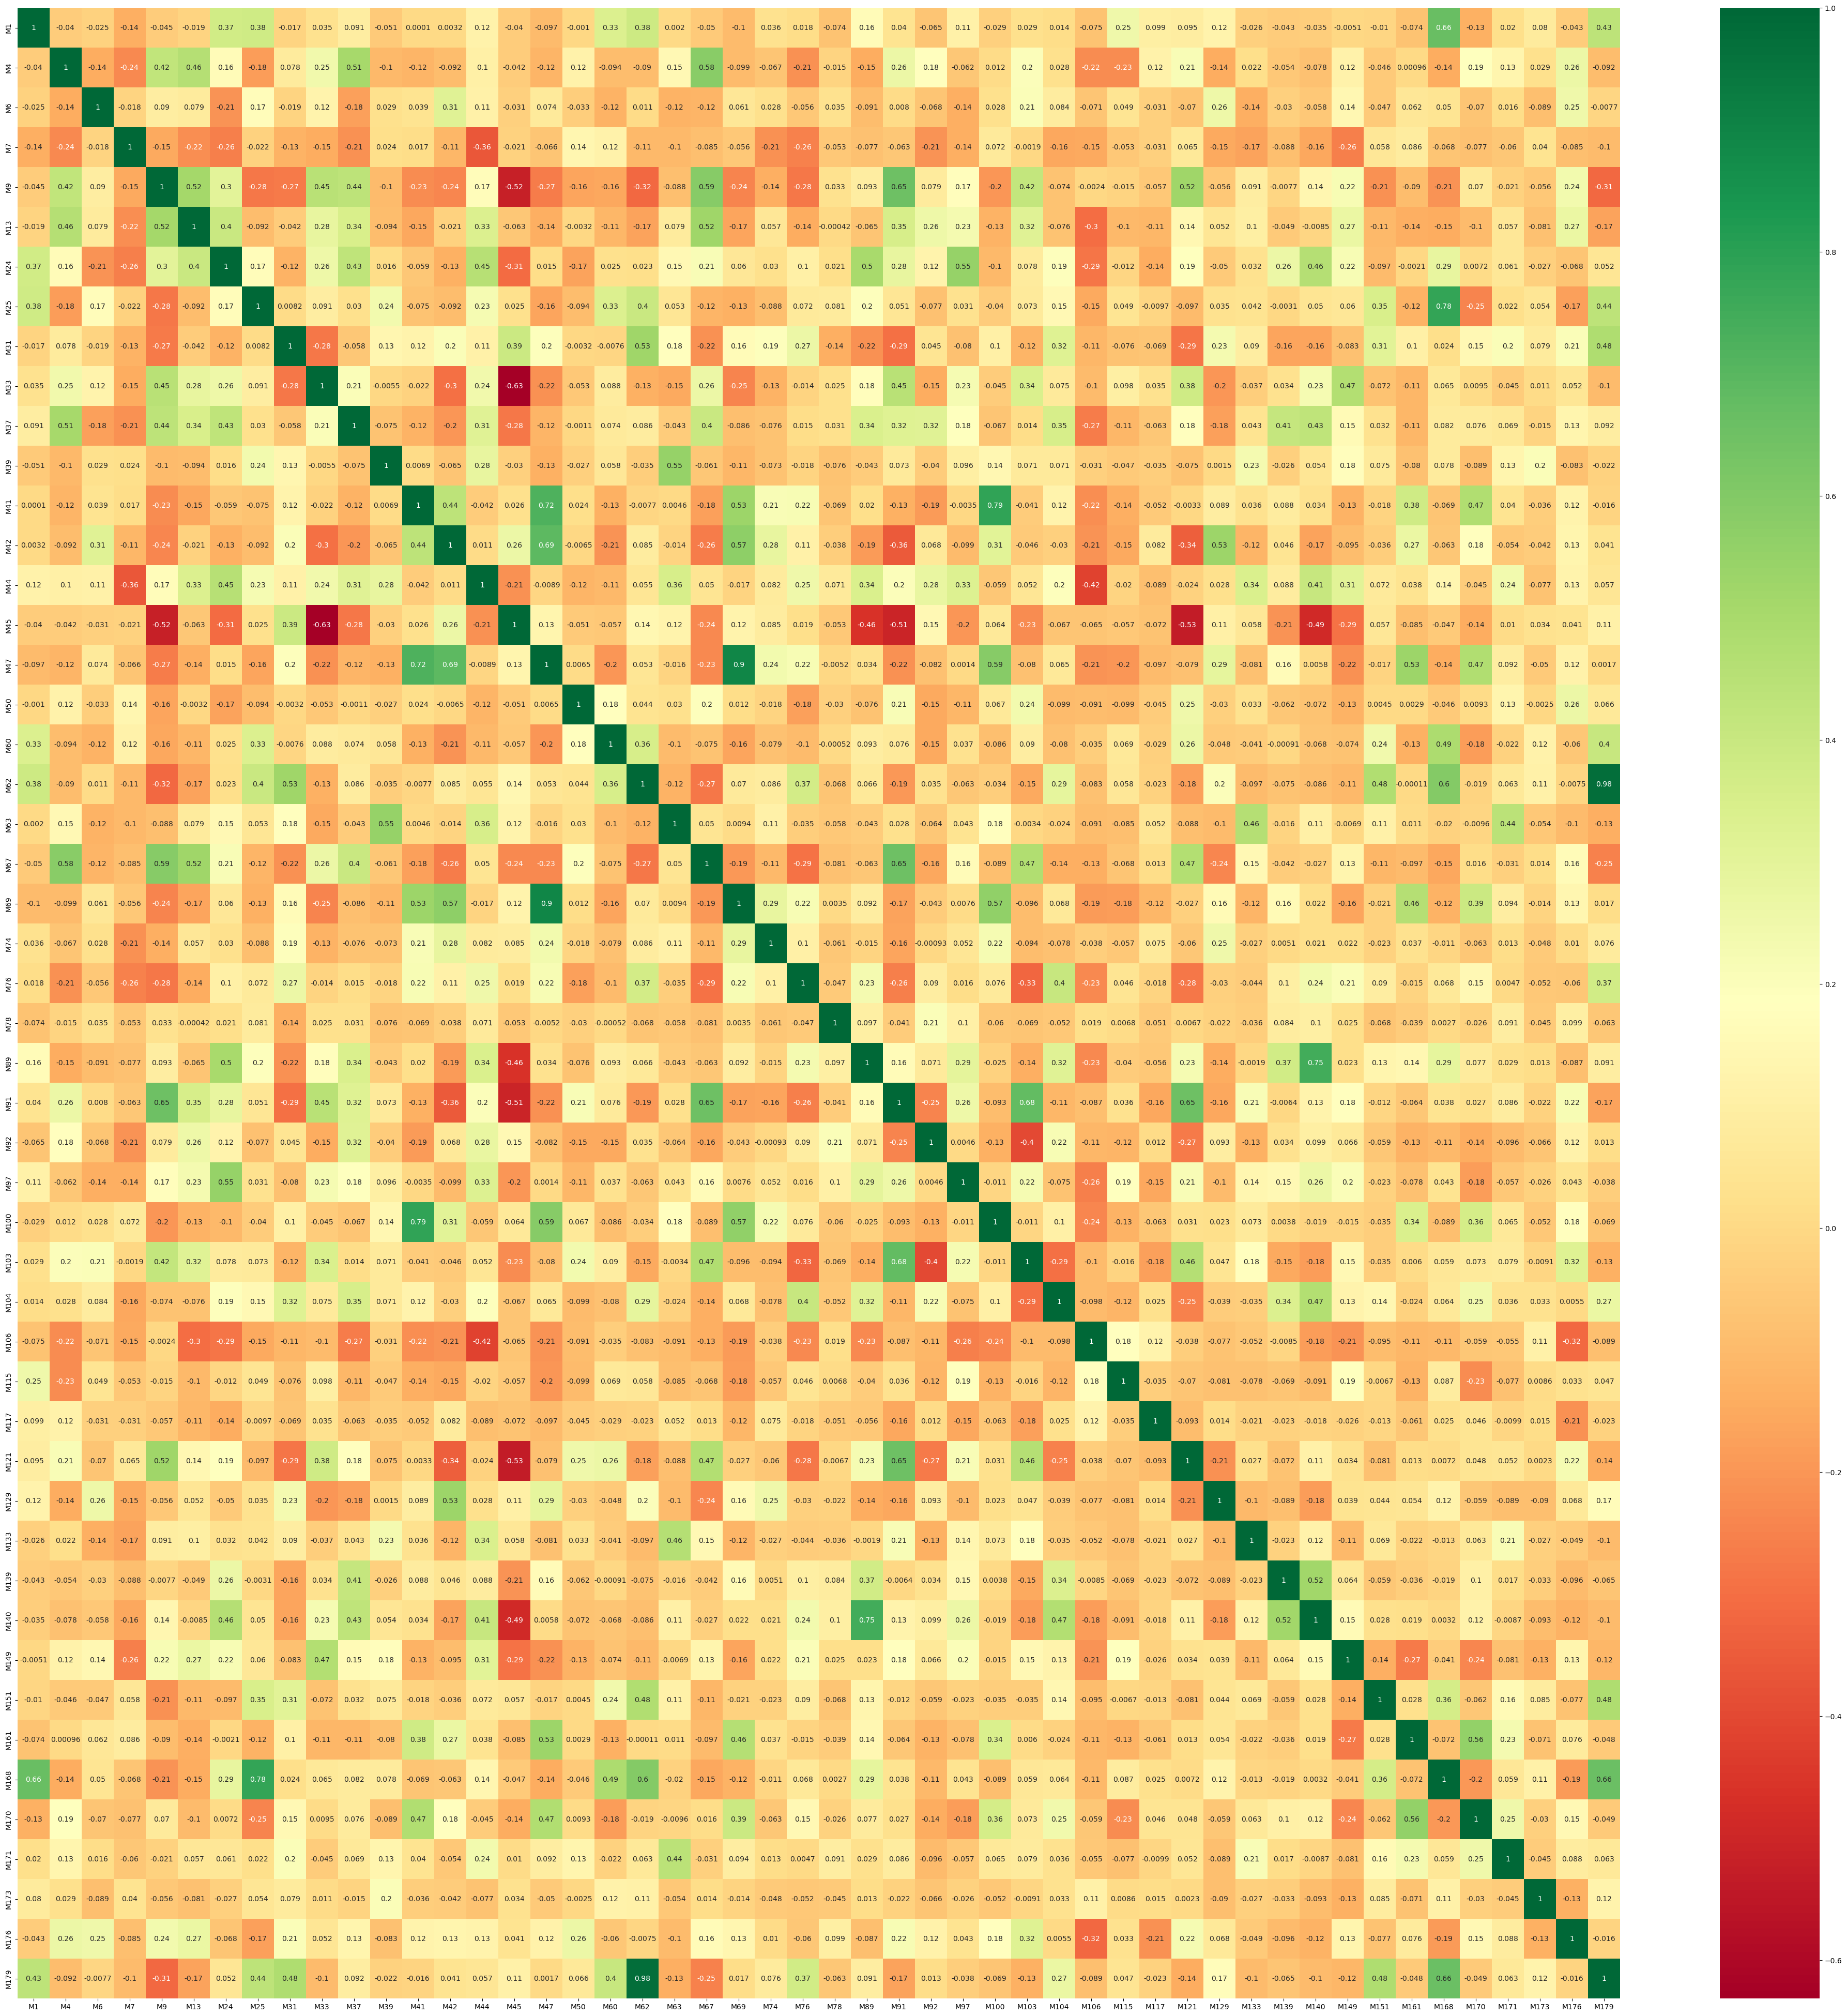

In [49]:
# Otteniamo le correlazioni tra le features
corrmat = X_top.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(k_fs, k_fs))

# Generiamo il grafico delle correlazioni
g=sns.heatmap(X_top[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### 8. PCA

In [50]:
pca = PCA()
pca.fit(X_knn)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.8) + 1
print("Numero di componenti principali:", d)

pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_knn)

Numero di componenti principali: 3


In [51]:
scores = cross_val_score(best_model, X_reduced, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.6140350877192982


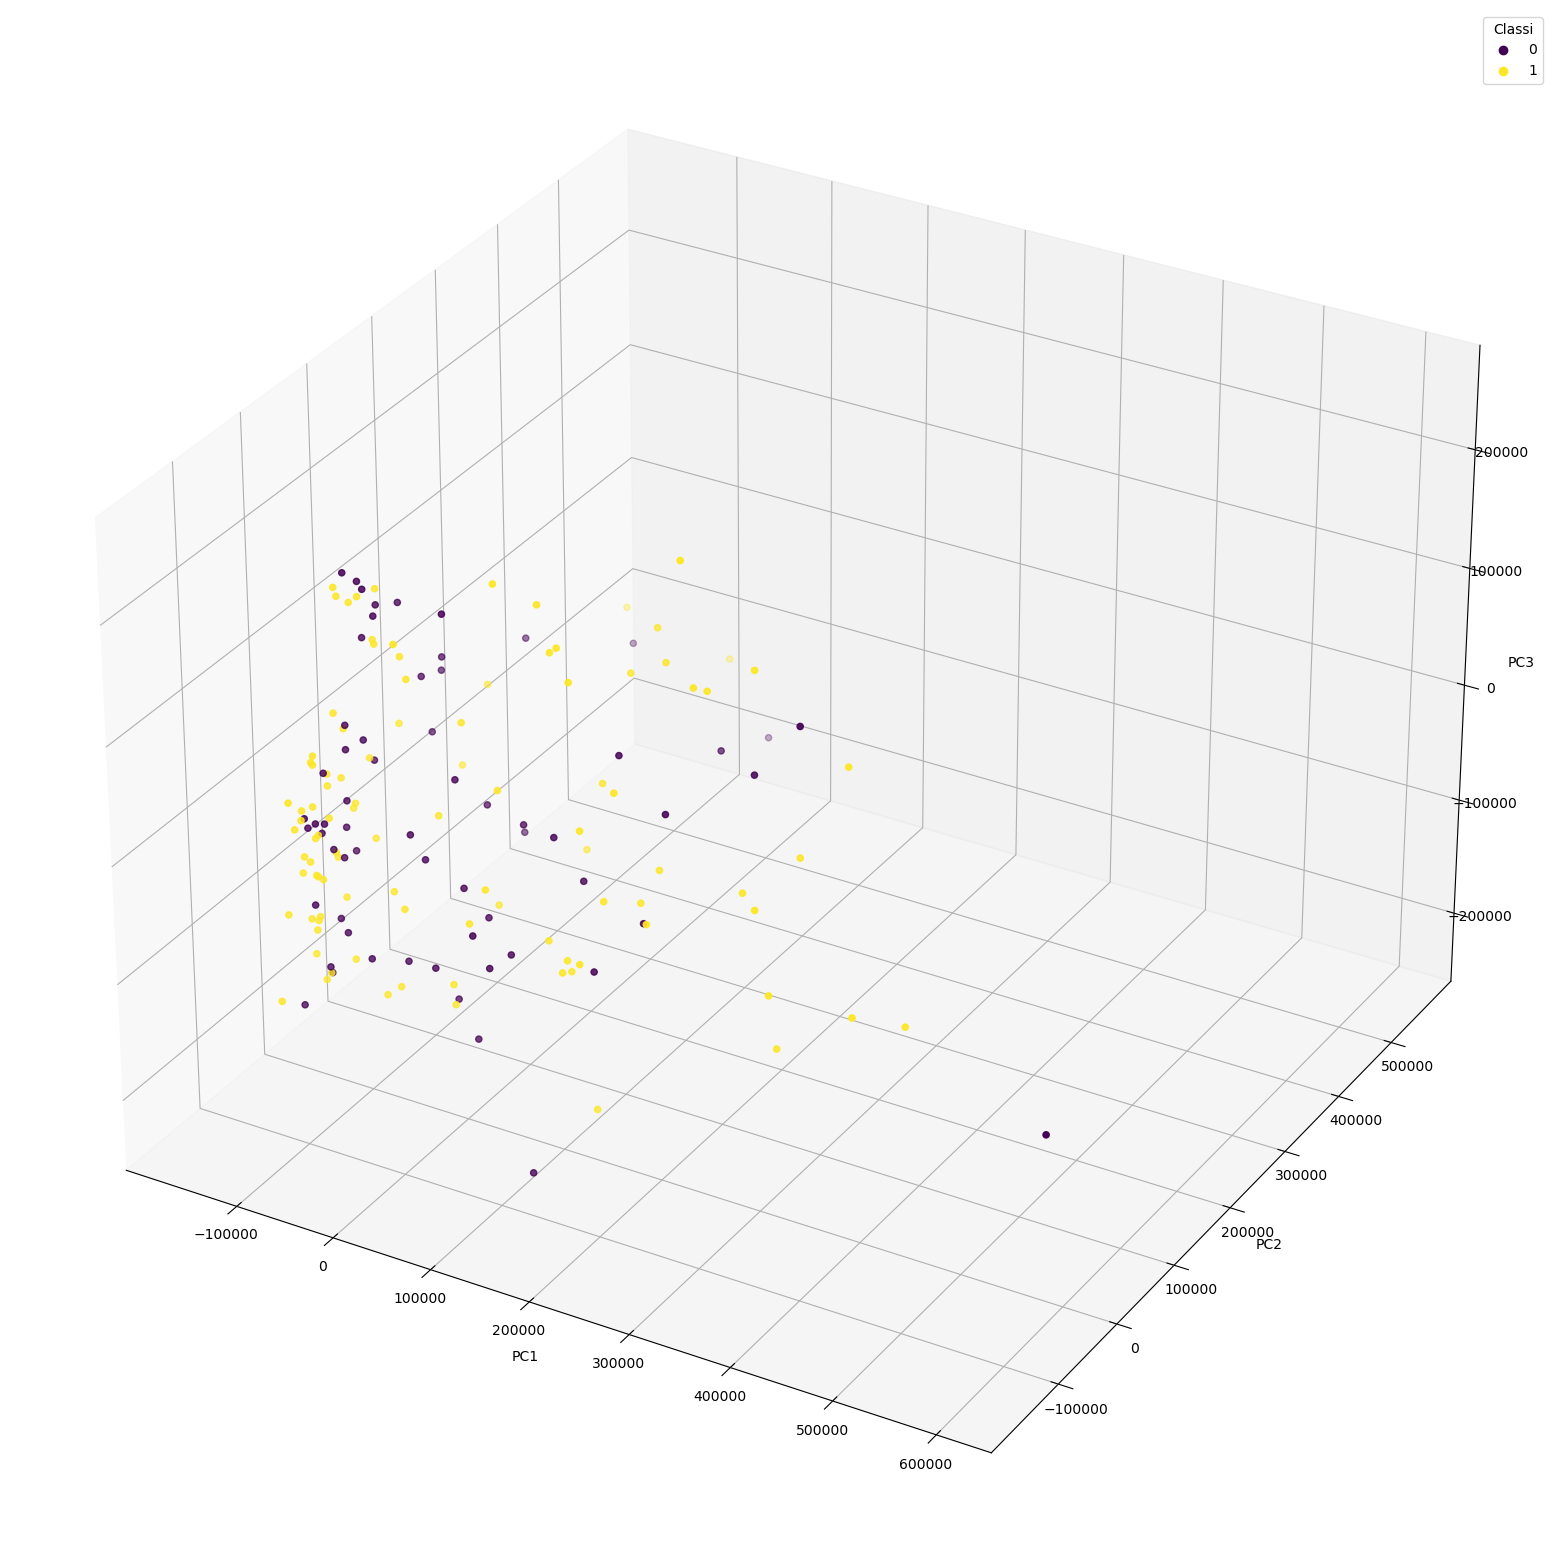

In [52]:
# Creazione di un grafico 3D
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plotting dei punti nel grafico 3D
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap='viridis')

# Aggiungi etichette agli assi
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Aggiungiamo una legenda per i colori
legend = ax.legend(*scatter.legend_elements(), title='Classi')

# Mostriamo il grafico
plt.show()


### 9. Results

Elenchiamo i risultati migliori: 

In [53]:
# Numero ottimale di fold
kfolds = KFold(n_splits=k_best, shuffle=True, random_state=42)

# Modello AdaBoost con gli iperparametri ottimizzati
model = AdaBoostClassifier(**best_params)

# K-Fold Cross Validation del modello con le features ottimali
y_pred = cross_val_predict(model, X_top, y, cv=kfolds, method='predict_proba')

# Scegliamo na soglia (threshold) per trasformare le probabilità in etichette binarie
threshold = 0.5
y_pred = (y_pred[:, 1] > threshold).astype(int)

# Calcoliamo le metriche
accuracy = metrics.accuracy_score(y, y_pred)
precision = metrics.precision_score(y, y_pred)
recall = metrics.recall_score(y, y_pred)
f1 = metrics.f1_score(y, y_pred)
roc_auc = metrics.roc_auc_score(y, y_pred)

In [54]:
# Stampiamo i risultati
print("------------------------")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

print("------------------------")
print(f'Matrice di confusione:\n {metrics.confusion_matrix(y, y_pred)}')
print("------------------------")
print(f'Migliori iperparametri:')
for h in best_params:
    print(f'- {h}: {best_params[h]}')
print("------------------------")
print(f'Features selezionate: {len(best_features)}')
print("------------------------")

------------------------
Accuracy: 0.8098
Precision: 0.8557
Recall: 0.8300
F1-score: 0.8426
ROC AUC: 0.8039
------------------------
Matrice di confusione:
 [[49 14]
 [17 83]]
------------------------
Migliori iperparametri:
- algorithm: SAMME.R
- estimator: None
- learning_rate: 1.0
- n_estimators: 100
- random_state: 42
------------------------
Features selezionate: 50
------------------------


### 10. ROC Curve

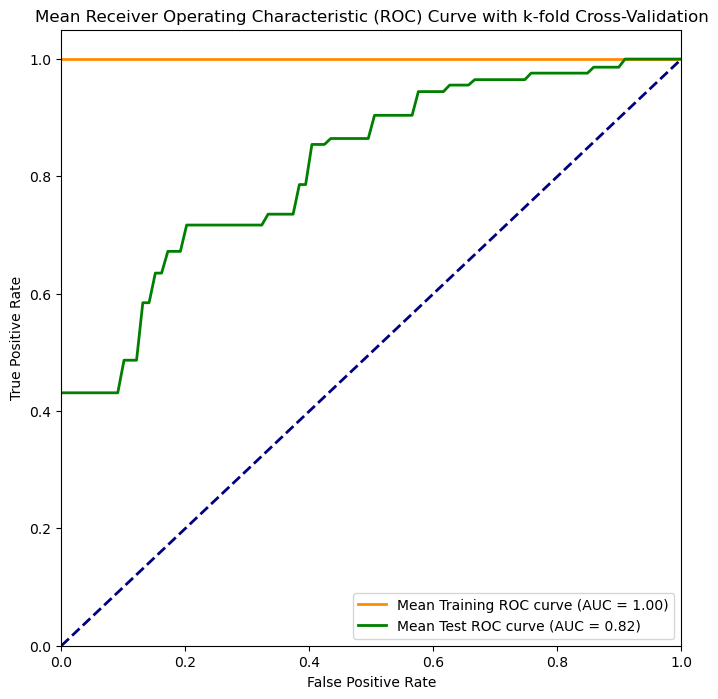

In [57]:
# Inizializziamo le liste per memorizzare i risultati dei singoli fold
all_fpr_train = []
all_tpr_train = []
all_fpr_test = []
all_tpr_test = []

# Eseguiamo la k-fold cross-validation
for train_idx, test_idx in kfolds.split(X_top, y):
    X_train, X_test = X_top.iloc[train_idx], X_top.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Addestriamo il modello sul training set
    model.fit(X_train, y_train)

    # Calcoliamo le probabilità di classe per i dati di training e test
    y_train_probs = model.predict_proba(X_train)[:, 1]
    y_test_probs = model.predict_proba(X_test)[:, 1]

    # Calcoliamo la curva ROC per i dati di training
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    all_fpr_train.append(fpr_train)
    all_tpr_train.append(tpr_train)

    # Calcoliamo la curva ROC per i dati di test
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
    all_fpr_test.append(fpr_test)
    all_tpr_test.append(tpr_test)

# Calcoliamo le curve ROC medie per i dati di training
mean_fpr_train = np.linspace(0, 1, 100)
mean_tpr_train = np.mean([np.interp(mean_fpr_train, fpr, tpr) for fpr, tpr in zip(all_fpr_train, all_tpr_train)], axis=0)
roc_auc_train = auc(mean_fpr_train, mean_tpr_train)

# Calcoliamo le curve ROC medie per i dati di test
mean_fpr_test = np.linspace(0, 1, 100)
mean_tpr_test = np.mean([np.interp(mean_fpr_test, fpr, tpr) for fpr, tpr in zip(all_fpr_test, all_tpr_test)], axis=0)
roc_auc_test = auc(mean_fpr_test, mean_tpr_test)

# Grafichiamo le curve ROC medie
plt.figure(figsize=(8, 8))
plt.plot(mean_fpr_train, mean_tpr_train, color='darkorange', lw=2, label=f'Mean Training ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(mean_fpr_test, mean_tpr_test, color='green', lw=2, label=f'Mean Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean Receiver Operating Characteristic (ROC) Curve with k-fold Cross-Validation')
plt.legend(loc="lower right")
plt.show()

In [60]:
y_train_pred = cross_val_predict(model, X_train, y_train, cv=kfolds)
y_test_pred = cross_val_predict(model, X_test, y_test, cv=kfolds)

print("Metriche di valutazione per il training set:")
print("Accuratezza:", metrics.accuracy_score(y_train, y_train_pred))
print("Precisione:", metrics.precision_score(y_train, y_train_pred))
print("Recall:", metrics.recall_score(y_train, y_train_pred))
print("F1-score:", metrics.f1_score(y_train, y_train_pred))

print("\nMetriche di valutazione per il test set:")
print("Accuratezza:", metrics.accuracy_score(y_test, y_test_pred))
print("Precisione:", metrics.precision_score(y_test, y_test_pred))
print("Recall:", metrics.recall_score(y_test, y_test_pred))
print("F1-score:", metrics.f1_score(y_test, y_test_pred))

Metriche di valutazione per il training set:
Accuratezza: 0.7931034482758621
Precisione: 0.8202247191011236
Recall: 0.8390804597701149
F1-score: 0.8295454545454546

Metriche di valutazione per il test set:
Accuratezza: 0.6111111111111112
Precisione: 0.6875
Recall: 0.8461538461538461
F1-score: 0.7586206896551724


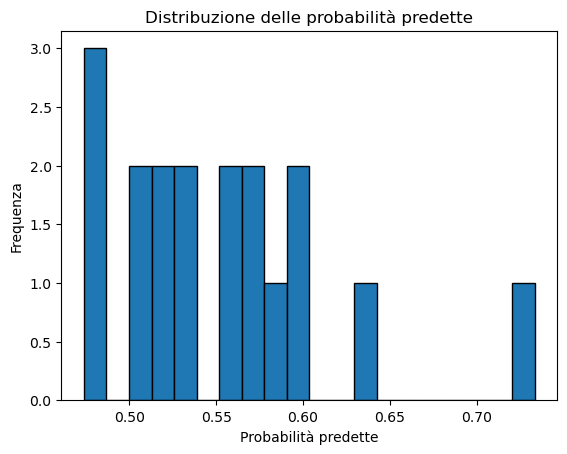

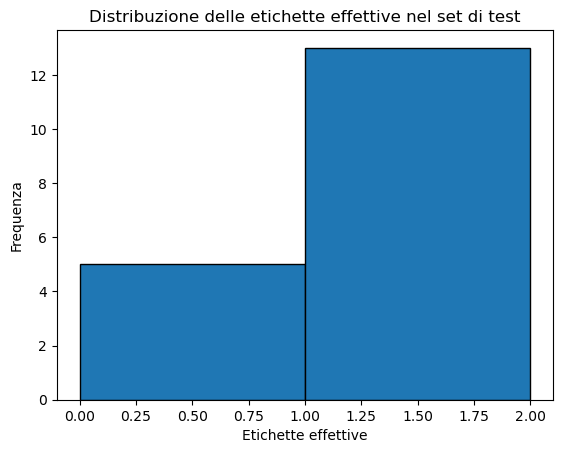

In [63]:

# Plotta un istogramma delle probabilità predette
plt.hist(y_test_probs, bins=20, edgecolor='black')
plt.xlabel('Probabilità predette')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle probabilità predette')
plt.show()

# Plotta un istogramma delle etichette effettive nel set di test
plt.hist(y_test, bins=[0, 1, 2], edgecolor='black')
plt.xlabel('Etichette effettive')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle etichette effettive nel set di test')
plt.show()

